
# Data Analysis

* This notebook performs analysis on the articles with the following methods: 
* 1. Frequency Lists & N-gram analyis
  2. Keyness Analysis & Topic modeling
  3. Register Analysis
---

## Importing Clean Data & Necessary Libraries



In [8]:
import json
from collections import Counter
from nltk.util import ngrams
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Commjhub/jupyterhub/home/andrewc-lu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Commjhub/jupyterhub/home/andrewc-lu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
street_articles = json.load(open('../data/articles_34st.json'))

## Identifying Themes of Mental Health

#### Creating the Necessary Functions to Perform N-Gram Analysis

In [10]:
stop_words = set(stopwords.words('english'))

def tokenize(text):
    text = text.lower()
    punctuation = ".,!?;:'\"()[]{}<>-"
    for char in punctuation:
        text = text.replace(char, "")
    tokens = text.split()
    return tokens

def preprocess_text(text):
    text = text.lower()
    tokens = tokenize(text)
    return [word for word in tokens if word.isalpha() and word not in stop_words]


# Filter for articles discussing mental health
def filter_articles(articles, keywords):
    relevant_articles = []
    for article in articles:
        content = article.get("content", "")
        if any(keyword in content.lower() for keyword in keywords):
            relevant_articles.append(content)
    return relevant_articles

# Generate n-grams
def make_ngrams(texts, n=2):
    all_ngrams = []
    for text in texts:
        tokens = preprocess_text(text)
        all_ngrams.extend(ngrams(tokens, n))
    return Counter(all_ngrams)

mental_health_keywords = ["mental health", "emotional", "wellness", "stress", "burnout", "anxiety", "depression"]


### Which years had the most articles related to mental health?

In [11]:
def filter_articles_by_year(articles, keywords):
    articles_by_year = {}
    total_articles_by_year = {}
    
    for article in articles:
        content = article.get("content", "")
        published_date = article.get("published_date", "")
        year = published_date.split('-')[0] if published_date else None
        
        if year:
            # Count the total articles for each year
            if year in total_articles_by_year:
                total_articles_by_year[year] += 1
            else:
                total_articles_by_year[year] = 1
            
            # Count mental health-related articles
            if any(keyword in content.lower() for keyword in keywords):
                if year in articles_by_year:
                    articles_by_year[year] += 1
                else:
                    articles_by_year[year] = 1

    return articles_by_year, total_articles_by_year

# Get the counts of mental health-related and total articles by year
articles_by_year, total_articles_by_year = filter_articles_by_year(street_articles, mental_health_keywords)

# Calculate the ratio of mental health articles to total articles for each year
yearly_ratios = {}
for year in articles_by_year:
    total_articles = total_articles_by_year.get(year, 0)
    if total_articles > 0:
        yearly_ratios[year] = articles_by_year[year] / total_articles
    else:
        yearly_ratios[year] = 0

# Print the year with the most mental health-related articles
most_articles_year = max(articles_by_year, key=articles_by_year.get)
print(f"The year with the most mental health-related articles is: {most_articles_year}")
print(f"Number of mental health-related articles in {most_articles_year}: {articles_by_year[most_articles_year]}")

# Print the table showing the ratio of mental health articles to total articles by year
print("\nYear | Mental Health Articles | Total Articles | Ratio")
print("="*60)

for year in sorted(yearly_ratios.keys()):
    mental_health_count = articles_by_year.get(year, 0)
    total_articles_count = total_articles_by_year.get(year, 0)
    ratio = yearly_ratios[year]
    print(f"{year: <6} | {mental_health_count: <19} | {total_articles_count: <14} | {ratio:.4f}")


The year with the most mental health-related articles is: 2021
Number of mental health-related articles in 2021: 232

Year | Mental Health Articles | Total Articles | Ratio
2020   | 198                 | 596            | 0.3322
2021   | 232                 | 616            | 0.3766
2022   | 177                 | 492            | 0.3598
2023   | 124                 | 388            | 0.3196
2024   | 111                 | 310            | 0.3581


However, it is important to note that the results may be skewed for 2024 as the year hasn't ended yet, and thus there are much less articles. As a result, the ratio of mental health articles will be skewed to be higher. 

#### Displaying our findings with a bar chart

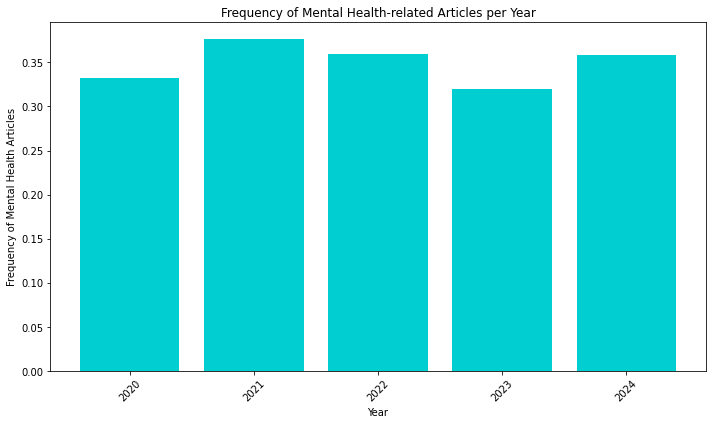

In [12]:
total_articles_by_year = {}
mental_health_articles_by_year = {}

for article in street_articles:
    published_date = article.get("published_date", "")
    if published_date:
        date_part = published_date.split(" ")[0]
        year, _, _ = date_part.split("-")

        if year not in total_articles_by_year:
            total_articles_by_year[year] = 0
        total_articles_by_year[year] += 1

        content = article.get("content", "").lower()
        if any(keyword in content for keyword in mental_health_keywords): 
            if year not in mental_health_articles_by_year:
                mental_health_articles_by_year[year] = 0
            mental_health_articles_by_year[year] += 1

# Prepare data for plotting
years = list(total_articles_by_year.keys())
total_article_counts = [total_articles_by_year[year] for year in years]
mental_health_article_counts = [mental_health_articles_by_year.get(year, 0) for year in years]

# Calculate frequency (mental health articles / total articles) for each year
frequencies = [mh_count / total_count if total_count > 0 else 0
               for mh_count, total_count in zip(mental_health_article_counts, total_article_counts)]

# Reverse the lists to ensure chronological order
years.reverse()
frequencies.reverse()

# Create a bar plot showing the frequency of mental health articles
plt.figure(figsize=(10, 6))

plt.bar(years, frequencies, color='darkturquoise')

plt.xlabel('Year')
plt.ylabel('Frequency of Mental Health Articles')
plt.title('Frequency of Mental Health-related Articles per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Examining fluctuations in mental health articles by month

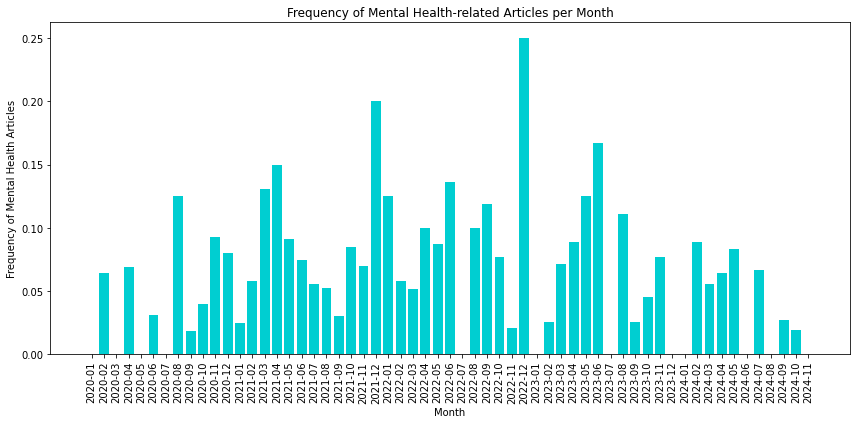

In [13]:
articles_by_month = {}
total_articles_by_month = {}

for article in street_articles:
    published_date = article.get("published_date", "")
    if published_date:
        date_part = published_date.split(" ")[0]
        year, month, _ = date_part.split("-")
        year_month = f"{year}-{month}"

        if year_month not in articles_by_month:
            articles_by_month[year_month] = 0
            total_articles_by_month[year_month] = 0
        
        # Count total articles and mental health-related articles
        total_articles_by_month[year_month] += 1
        if "mental health" in article.get("content", "").lower():
            articles_by_month[year_month] += 1

months = list(articles_by_month.keys())
mental_health_article_counts_month = list(articles_by_month.values())
total_article_counts_month = [total_articles_by_month[month] for month in months]

# Calculate the frequency of mental health articles for each month 
frequencies_monthly = [mh_count / total_count if total_count > 0 else 0
                       for mh_count, total_count in zip(mental_health_article_counts_month, total_article_counts_month)]

# Reverse the lists to ensure chronological order
months.reverse()
frequencies_monthly.reverse()


plt.figure(figsize=(12, 6))

plt.bar(months, frequencies_monthly, color='darkturquoise')

plt.xlabel('Month')
plt.ylabel('Frequency of Mental Health Articles')
plt.title('Frequency of Mental Health-related Articles per Month')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The monthly plot of mental health-related articles reveals some key trends tied to the academic calendar. Spikes in article counts are observed around the start of each school semester, particularly in the months of September to December and February to April, which suggests that as students return to school and face academic challenges, mental health topics become more prominent in discussions. This aligns with the natural rhythms of student life, where periods of high academic stress might lead to more articles being written.

However, the overall decline in the number of mental health-related articles over time is notable. This dip, especially post-pandemic, could indicate that students are facing fewer mental health challenges compared to the height of the pandemic. This pattern could suggest that students are shifting their focus to other aspects of their lives and studies, leading to a decrease in a desire to cover mental health struggles, and instead more variety in content.

### Examining Mental Health N-grams by year 

In [14]:
# Modifying the filter_articles_by_year so we can iterate through the text
def filter_articles_year_words(articles, keywords):
    articles_year_words = {}

    for article in articles:
        content = article.get("content", "")
        if any(keyword in content.lower() for keyword in keywords):
            year = article.get("published_date", "").split('-')[0]
            if year:  
                if year in articles_year_words:
                    articles_year_words[year].append(content) 
                else:
                    articles_year_words[year] = [content] 

    return articles_year_words

In [15]:
ngrams_by_year = {}
n_grams_years = filter_articles_year_words(street_articles, mental_health_keywords)
for year, articles in n_grams_years.items():
    ngrams_by_year[year] = make_ngrams(articles, n=2)


def get_top_ngrams_by_year(ngrams_by_year, top_n=10):
    top_ngrams_by_year = {}
    
    for year, ngrams_count in ngrams_by_year.items():
        # Count the frequency of each n-gram
        ngram_freq = Counter(ngrams_count)
        # Get the top N n-grams
        top_ngrams_by_year[year] = ngram_freq.most_common(top_n)
    
    return top_ngrams_by_year

# Obtaining the top 10 n_grams by year
top_ngrams_by_year = get_top_ngrams_by_year(ngrams_by_year, top_n=10)
top_ngrams_by_year

{'2024': [(('social', 'media'), 45),
  (('new', 'york'), 38),
  (('feel', 'like'), 38),
  (('high', 'school'), 33),
  (('bike', 'lanes'), 30),
  (('penn', 'students'), 25),
  (('mental', 'health'), 23),
  (('united', 'states'), 22),
  (('first', 'time'), 19),
  (('every', 'day'), 19)],
 '2023': [(('mental', 'health'), 77),
  (('high', 'school'), 54),
  (('feel', 'like'), 47),
  (('social', 'media'), 45),
  (('penn', 'students'), 44),
  (('new', 'york'), 42),
  (('asteroid', 'city'), 30),
  (('united', 'states'), 28),
  (('water', 'bottle'), 27),
  (('locust', 'walk'), 26)],
 '2022': [(('mental', 'health'), 103),
  (('social', 'media'), 86),
  (('high', 'school'), 73),
  (('feel', 'like'), 66),
  (('palliative', 'care'), 48),
  (('penn', 'students'), 42),
  (('united', 'states'), 40),
  (('first', 'time'), 39),
  (('even', 'though'), 36),
  (('food', 'insecurity'), 35)],
 '2021': [(('high', 'school'), 115),
  (('mental', 'health'), 114),
  (('feel', 'like'), 97),
  (('social', 'media'),

The phrase "mental health" appears consistently across all years, with its frequency peaking in 2022 (103 occurrences), followed by 2021 (114 occurrences). However, its presence slightly decreases in 2023 (77) and 2024 (23). This suggests that while mental health has been a significant topic, its emphasis in magazine content has waned in recent years, particularly in 2024.

"Social media" appears frequently across all years, especially in 2022 (86 occurrences) and 2023 (45 occurrences), indicating that discussions about the impact of social media on mental health have been consistently relevant. This may reflect increasing concern about the mental health effects of social media platforms on youth and young adults, particularly in the wake of the pandemic and heightened digital engagement. Social media is intertwined with mental health, and its impacts are significant. 

From 2020 to 2021, there was a notable increase in articles with bigrams related to "Instagram post", "view post", and "post shared". This shift likely reflects the growing influence of social media platforms during the pandemic, as students and individuals increasingly used digital platforms to discuss mental health.

## Sentiment Analysis

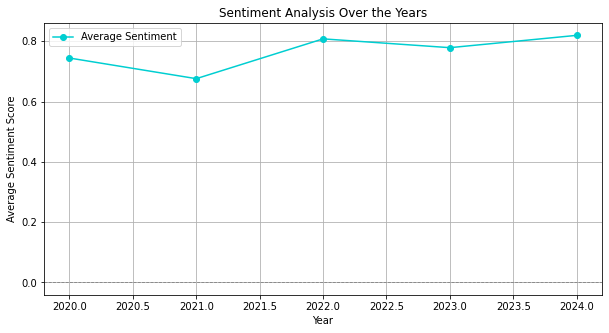

In [16]:
sia = SentimentIntensityAnalyzer()

def sentiment_analysis_per_year(articles):
    sentiments = defaultdict(list)
    
    for article in articles:
        content = article.get('content', '')
        year = article.get('year')
        if content and year:
            sentiment_score = sia.polarity_scores(content)
            sentiments[year].append(sentiment_score['compound'])
    

    avg_sentiments = {year: sum(scores) / len(scores) for year, scores in sentiments.items() if scores}
    return avg_sentiments


sentiment_scores = sentiment_analysis_per_year(street_articles)

plt.figure(figsize=(10, 5))
years = sorted(sentiment_scores.keys())
avg_scores = [sentiment_scores[year] for year in years]

plt.plot(years, avg_scores, marker='o', color="#00CED1", label='Average Sentiment')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8) 
plt.title('Sentiment Analysis Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.grid()
plt.show()


## Examine sentiment across years and section

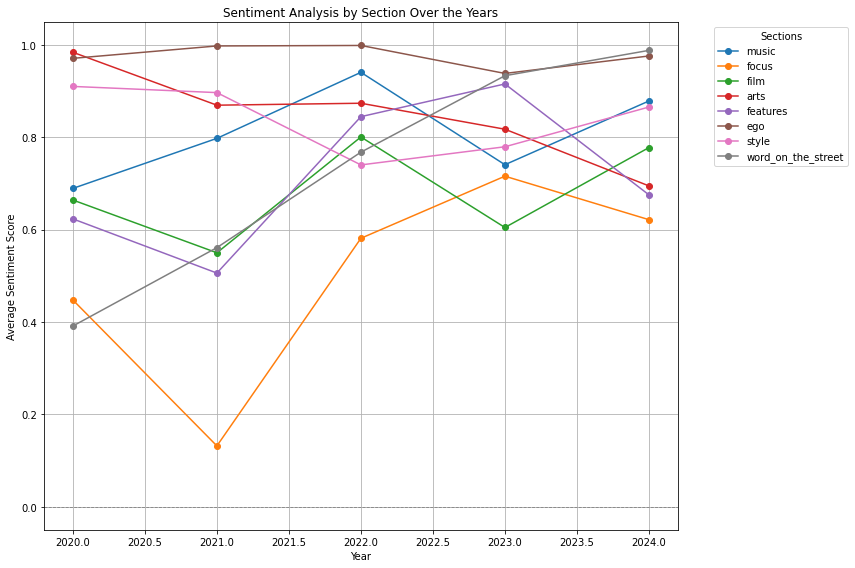

In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import defaultdict
import matplotlib.pyplot as plt

# Instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()

def sentiment_analysis_per_section_and_year(articles):
    sentiments_by_section = defaultdict(lambda: defaultdict(list))
    
    for article in articles:
        content = article.get('content', '')
        year = article.get('year')
        section = article.get('section', 'unknown')  # Default to 'unknown' if no section
        
        if content and year and section:
            # Calculate sentiment scores
            sentiment_score = sia.polarity_scores(content)
            # Group sentiment by section and year
            sentiments_by_section[section][year].append(sentiment_score['compound'])
    
    # Calculate average sentiment scores per section per year
    avg_sentiments = {
        section: {year: sum(scores) / len(scores) for year, scores in year_scores.items() if scores}
        for section, year_scores in sentiments_by_section.items()
    }
    return avg_sentiments

# Perform sentiment analysis
avg_sentiments_by_section = sentiment_analysis_per_section_and_year(street_articles)

# Plot results for each section
plt.figure(figsize=(12, 8))
for section, year_scores in avg_sentiments_by_section.items():
    years = sorted(year_scores.keys())
    avg_scores = [year_scores[year] for year in years]
    plt.plot(years, avg_scores, marker='o', label=section)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Neutral line
plt.title('Sentiment Analysis by Section Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.legend(title="Sections", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()


In [32]:
print("Average Sentiment Scores by Section and Year:")
for section, year_scores in avg_sentiments_by_section.items():
    print(f"\nSection: {section}")
    for year, avg_score in sorted(year_scores.items()):
        print(f"  Year {year}: {avg_score:.3f}")

Average Sentiment Scores by Section and Year:

Section: music
  Year 2020: 0.689
  Year 2021: 0.797
  Year 2022: 0.940
  Year 2023: 0.740
  Year 2024: 0.878

Section: focus
  Year 2020: 0.448
  Year 2021: 0.132
  Year 2022: 0.581
  Year 2023: 0.715
  Year 2024: 0.621

Section: film
  Year 2020: 0.664
  Year 2021: 0.550
  Year 2022: 0.800
  Year 2023: 0.604
  Year 2024: 0.777

Section: arts
  Year 2020: 0.984
  Year 2021: 0.869
  Year 2022: 0.873
  Year 2023: 0.817
  Year 2024: 0.694

Section: features
  Year 2020: 0.623
  Year 2021: 0.506
  Year 2022: 0.844
  Year 2023: 0.915
  Year 2024: 0.675

Section: ego
  Year 2020: 0.971
  Year 2021: 0.997
  Year 2022: 0.998
  Year 2023: 0.938
  Year 2024: 0.976

Section: style
  Year 2020: 0.910
  Year 2021: 0.896
  Year 2022: 0.740
  Year 2023: 0.779
  Year 2024: 0.865

Section: word_on_the_street
  Year 2020: 0.391
  Year 2021: 0.561
  Year 2022: 0.767
  Year 2023: 0.933
  Year 2024: 0.988


## What is the content of these mental health articles?

Now that we know there is a dip in sentiment alongside an increase of mental health related articles in 2021, it is likely that it is the effect of the pandemic that has resulted negative mental health effects. Let us examine the context for the top n-grams of each year. 

In [18]:
# KWIC function as defined earlier
def kwic_analysis(articles, ngram, window=5):
    kwic_results = []
    for article in articles:
        tokens = tokenize(article)  
        ngram_tokens = ngram.split()
        n = len(ngram_tokens)
        
        # Find all occurrences of the n-gram
        for i in range(len(tokens) - n + 1):
            if tokens[i:i + n] == ngram_tokens:
                # Extract context window
                start = max(0, i - window)
                end = min(len(tokens), i + n + window)
                context = " ".join(tokens[start:end])
                kwic_results.append(context)
    
    return kwic_results

# Perform KWIC analysis for the top n-gram of each year
kwic_results_by_year = {}
for year, top_ngrams in top_ngrams_by_year.items():
    if top_ngrams: 
        top_ngram = " ".join(top_ngrams[0][0])  
        articles_for_year = n_grams_years.get(year, [])  
        kwic_results = []

        # Perform KWIC analysis for this n-gram
        for article in articles_for_year:
            kwic_results.extend(kwic_analysis([article], top_ngram, window=5))
        
        kwic_results_by_year[year] = {
            "ngram": top_ngram,
            "contexts": kwic_results[:10]
        }

# Display KWIC results by year
for year, result in kwic_results_by_year.items():
    print(f"Year: {year}")
    print(f"Top N-gram: {result['ngram']}")
    print("Contexts:")
    for context in result["contexts"]:
        print(f"- {context}")
    print("\n")


Year: 2024
Top N-gram: social media
Contexts:
- with the same one–word prompt social media timelines are flooded with thousands
- high schools the impact of social media by bringing in local legislators
- difficult in the age of social media wang says that for students
- social media” this overdependence on social media leads predictably to polarizing opinions
- over half of teens used social media to get news beyond contributing
- news beyond contributing to misinformation social media also has another unintended effect
- some cases ai videos and social media posts about the legitimacy of
- disinformation has become prevalent on social media and those who are on
- algorithms creating echo chambers however social media has positive engagement impacts especially
- do digital testimonies on our social media about how these things are


Year: 2023
Top N-gram: mental health
Contexts:
- charge of their physical and mental health every year the college hosts
- looking at violence through a m

### Sentiment analysis on the context surrounding these n-grams

In [19]:
def sentiment_analysis_kwic(kwic_results):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = [analyzer.polarity_scores(context) for context in kwic_results]
    return sentiment_scores

sentiment_by_year = {}
for year, result in kwic_results_by_year.items():
    kwic_contexts = result["contexts"]
    sentiments = sentiment_analysis_kwic(kwic_contexts)
    avg_sentiment = {
        "positive": sum(s["pos"] for s in sentiments) / len(sentiments),
        "neutral": sum(s["neu"] for s in sentiments) / len(sentiments),
        "negative": sum(s["neg"] for s in sentiments) / len(sentiments),
    }
    sentiment_by_year[year] = avg_sentiment

# Display sentiment by year
for year, sentiment in sentiment_by_year.items():
    print(f"Year: {year}")
    print(f"Sentiment: {sentiment}")
    print("\n")


Year: 2024
Sentiment: {'positive': 0.0494, 'neutral': 0.9148, 'negative': 0.0358}


Year: 2023
Sentiment: {'positive': 0.0819, 'neutral': 0.8723000000000001, 'negative': 0.045799999999999993}


Year: 2022
Sentiment: {'positive': 0.08009999999999999, 'neutral': 0.7657, 'negative': 0.1542}


Year: 2021
Sentiment: {'positive': 0.0593, 'neutral': 0.9407, 'negative': 0.0}


Year: 2020
Sentiment: {'positive': 0.1335, 'neutral': 0.7368, 'negative': 0.1298}




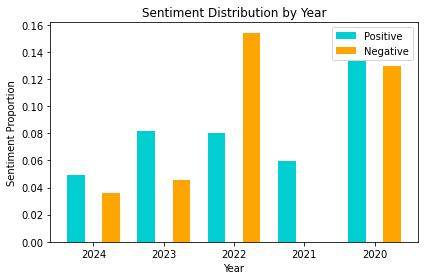

In [20]:
years = list(sentiment_by_year.keys())
positive = [sentiment_by_year[year]['positive'] for year in years]
neutral = [sentiment_by_year[year]['neutral'] for year in years]
negative = [sentiment_by_year[year]['negative'] for year in years]

# Side-by-side bar plot
bar_width = 0.25

# Create bar positions
indices = np.arange(len(years))

plt.bar(indices - bar_width, positive, bar_width, label='Positive', color='darkturquoise')
plt.bar(indices + bar_width, negative, bar_width, label='Negative', color='orange')

# Formatting
plt.xlabel('Year')
plt.ylabel('Sentiment Proportion')
plt.title('Sentiment Distribution by Year')
plt.xticks(indices, years)
plt.legend()

plt.tight_layout()
plt.show()

### 1. Shifts in Sentiment by Year
2024 ("social media"):
The sentiment around "social media" in 2024 is predominantly neutral (91.48%). This reflects the factual and descriptive nature of the content discussing the role of social media, focusing on its impact on disinformation, echo chambers, and engagement. While there are positive aspects (e.g., the potential for positive engagement) and negative consequences (e.g., the spread of misinformation), the overall tone remains largely informational. This could indicate a more analytical approach to understanding social media's societal role.

2023 ("mental health"):
Sentiment is more positive (8.19%) compared to 2024, with discussions focusing on mental health awareness, initiatives, and resources. The neutral sentiment (87.23%) suggests a tone of advocacy and factual presentation, emphasizing efforts to improve mental health care and access. There is a growing acknowledgment of mental health's importance, though the tone remains largely focused on raising awareness rather than engaging in emotional or personal appeals.

2022 ("mental health"):
There is a noticeable increase in negative sentiment (15.42%) in 2022, reflecting a more challenging discussion around mental health. The year’s context suggests struggles with mental health challenges like anxiety, depression, and the fallout from systemic neglect during the pandemic. The higher negative sentiment indicates that many of the discussions were focused on the difficulties individuals faced, likely exacerbated by societal and pandemic-related stressors.

2021 ("high school"):
In 2021, the sentiment surrounding "high school" is overwhelmingly neutral (94.07%), as the discussions are largely factual, focusing on experiences and personal reflections. Positive sentiment (5.93%) suggests moments of nostalgia and encouragement, particularly in discussions of high school’s influence on personal development. The neutral tone may reflect a focus on the routine and factual elements of high school life, with little emotional charge.

2020 ("mental health"):
In 2020, sentiment is more balanced, with positive sentiment (13.35%) alongside negative sentiment (12.98%). The mixed sentiment reflects the nuanced discussions around mental health, influenced by the COVID-19 pandemic. While there is optimism surrounding mental health resources and greater awareness, the negative sentiment likely reflects the growing concerns about anxiety, depression, and the challenges faced by individuals, particularly during the uncertainty of the pandemic.

### 2. Contextual Trends
2024 ("social media"):
The contexts around "social media" in 2024 focus heavily on its societal impact, particularly in areas like disinformation, echo chambers, and AI-related content. The focus on these issues indicates a growing awareness and criticism of social media's role in shaping public discourse and information consumption. These discussions are more critical compared to previous years, reflecting concerns over the negative consequences of social media’s influence.

2023 and 2022 ("mental health"):
Mental health continues to be a prominent theme in both 2023 and 2022, though the focus differs slightly between the years.

2023 emphasizes mental health awareness, initiatives, and the importance of improving access to mental health resources. The discussions focus more on positive action and support systems.
2022 delves into more challenging aspects of mental health, including food insecurity, pandemic stress, and systemic neglect. This context reflects the ongoing strain that individuals and communities experienced during the pandemic and its aftermath.
2021 ("high school"):
The focus in 2021 is largely on personal growth and the challenges posed by the pandemic. The discussions touch on how high school experiences shape individuals and communities, both in terms of academic preparation and personal reflections. These discussions are more reflective in nature, with less focus on immediate struggles and more on the long-term impact of high school life.

2020 ("mental health"):
Mental health discussions in 2020 are heavily shaped by the pandemic and the global mental health crisis that followed. The blend of concern and optimism reflects the uncertainty of the time, with discussions on coping strategies (e.g., humor, therapy, etc.) and the strain of anxiety and depression on Gen Z. These topics reflect a balance of stigma reduction and mental health awareness during a time of global upheaval.

### Key Observations and Implications
Mental Health Focus:
Across all years, mental health is a consistently prominent theme. The context surrounding mental health evolves from challenges (2020 and 2022) to a focus on awareness and action (2023). The increased attention to mental health could reflect a broader cultural shift toward prioritizing mental well-being, particularly in the wake of the pandemic.

In 2020, there is a strong emphasis on the negative effects of the pandemic on mental health, including depression, anxiety, and stigma.
By 2022, the tone shifts slightly, with more focus on systemic issues affecting mental health, such as neglect and food insecurity.
In 2023, the focus turns to positive actions like raising awareness and improving mental health resources. The positive sentiment in 2023 suggests that discussions are beginning to offer solutions rather than just focusing on problems.

Social Media Impact:
In 2024, social media takes focus on its negative impacts, such as misinformation and echo chambers. This marks a shift toward a more critical perspective on the role of social media in shaping public discourse and behavior, reflecting growing concerns about its influence on society.

High School Experience:
In 2021, the focus is on the personal growth and educational disruptions caused by the pandemic. The discussions about high school tend to be neutral or nostalgic, highlighting how the pandemic shaped students' academic and personal experiences.

## Conducting Topic Modeling

Now that we've conducted some introductory KWIC and sentiment analysis, we can look at some more advanced topic modeling.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV


In [22]:
docs = [article['content'] for article in street_articles]

In [23]:
english_stop_words = stopwords.words('english')
english_stop_words.extend(mental_health_keywords)

In [24]:
article_cnt_vect = CountVectorizer(
    token_pattern="[a-z][a-z'-]+",
    stop_words=english_stop_words,
    max_df=0.7,
    min_df=10,
    max_features=5000
)

In [25]:
articles_dtm = article_cnt_vect.fit_transform(docs)
                                              

/usr/local/anaconda3/share/jupyter/venv/py3_comm318/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['health', 'mental'] not in stop_words.
  warnings.warn(


In [26]:
N_topics = 7
article_LDA = LatentDirichletAllocation(n_components=N_topics,
                                        max_iter=10,
                                        learning_method='online',
                                        learning_offset=1,
                                        batch_size=256,
                                        random_state=0,
                                        verbose=1)

In [27]:
tm = article_LDA.fit_transform(articles_dtm)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [28]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_,1):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()

In [29]:
n_top_words=40
print("\nTopics in LDA model:\n====================\n")
tf_feature_names = article_cnt_vect.get_feature_names_out()
print_top_words(article_LDA, tf_feature_names, n_top_words)


Topics in LDA model:

Topic #1: says people students penn community philadelphia black many work health city support university public student change members american school political care would history social violence pandemic campus issues year years new center communities asian police workers need resources make first

Topic #2: love life first people would back day know way says get friends every never much still year feel new something make home us see could think things school world night around felt always two go want years work room away

Topic #3: film show movie characters story season character films series new world first shows many two love best episode however television movies life family still audience people comedy much yet though well way white watch may year stories see cast star

Topic #4: music album song songs pop love track new artists band first sound lyrics record swift fans year released artist release tracks two rock world musical best years would still grou

### Categorizing the Topics

From the above keywords, these topics can be categorized into the following approximate categories

1. Race, Social Justice, and Pandemic
2. Personal Experiences and Reflections
3. Film and TV
4. Music
5. Art, Social Media, and Beauty Standards
6. University Experience
7. Food and Culture

The first category is likely tied to specific global events, and the second category is likely tied to personal reflections and events that may cause stress. The next few topics tie specifically into sections: Film & TV, Music, Arts, and Style (which is meant to focus on University life and the student experience). Even the first two topics may align with sections. Both the Features and Focus section are geared towards covering current events, and the Word on the Street section covers personal essays from writers - aligning with topic 2. Topic 7 is mostly about food and restaurants: while not tied to a specific section, 34th Street publishes a dining guide full of restaurant reviews and food related content every year, which may explain it's prevalence. 

Overall, it seems the topics mostly align with the sections of the magazine. This is really interesting, as it shows that article subject matter is definitively corralled by the section groups that have been set out by the magazine. Whether or not those pre-determined sections are comprehensive or exhaustive is up for debate, but seem to capture many of the predicted key-words identified earlier. For example "pandemic" and "police" are two large stressors key to 2020. Additionally, the n-gram analysis from before predicted social media to be largely associated with our mental health key words, and words like "instagram" and "tiktok" appear frequently across the topic areas. 

### Plotting Trends Over Time in Topics

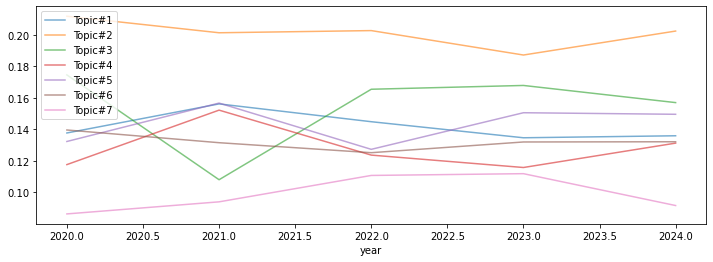

In [30]:
topic_df = pd.DataFrame(tm, columns=[f'Topic#{n}' for n in range(1,N_topics+1)])
years = [pd.to_datetime(article['published_date']).year for article in street_articles]
topic_df['year']=years
topic_df.set_index('year').groupby('year').agg('mean').sort_index().plot(style='-', figsize=(12,4), alpha=0.6)
plt.show()

### Adding Labels

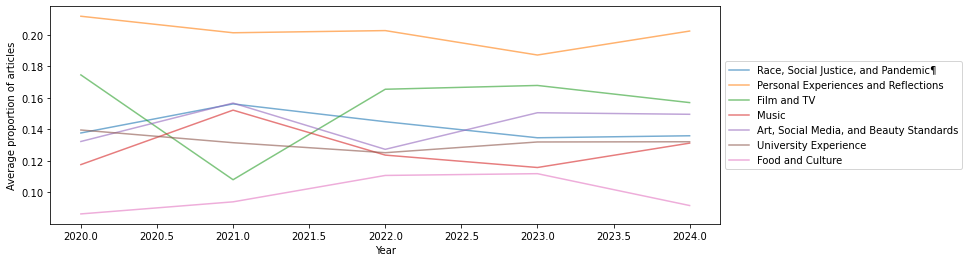

In [39]:
topic_labels_str = '''Topic 1: Race, Social Justice, and Pandemic
Topic 2: Personal Experiences and Reflections
Topic 3: Film and TV
Topic 4: Music
Topic 5: Art, Social Media, and Beauty Standards
Topic 6: University Experience
Topic 7: Food and Culture'''

topic_labels = [label.strip().split(': ')[1] for label in topic_labels_str.split('\n')]
                
topic_df = pd.DataFrame(tm, columns=[f'Topic#{n}' for n in range(1,N_topics+1)])
years = [pd.to_datetime(article['published_date']).year for article in street_articles]
topic_df['year']=years
ax=topic_df.set_index('year').groupby('year').agg('mean').sort_index().plot(style='-', figsize=(12,4), alpha=0.6)

ax.legend(labels = topic_labels, loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel('Year')
ax.set_ylabel('Average proportion of articles')
plt.show()

After plotting the distribution of these topics over time, a couple interesting trends emerge. First, Personal Experience and Reflections are routinely the top category. These key words likely appear in a broad range of articles in relation to student's personal experiences. 

Importantly, the Race, Social Justice and Pandemic Category was the second highest during 2021, with a steep drop off the following year. These key words related to global events are tied directly to that time period, but continue to be important afterwards. 

The last category is Art, Social Media, and Beauty Standards, which has risen to be the 2nd most common topic area in 2021 and 3rd after 2023. This demonstrates a change in what is likely causing mental health conflicts with students, as social media continues to emerge as a recurring trend.

Lastly, Film and TV consistently appears to be the second most common, which is interesting, although not immediately explainable. The rest of the categories have relatively consistent frequencies with varying prevalence. 